# Canine Cutaneous Tumor Segmentation

## Import Packages

In [1]:
import sys 
sys.path.insert(0, '..')
from fastai.utils.collect_env import show_install
from torchvision import transforms
from evaluation.metrics import *
from fastai.callbacks.tracker import SaveModelCallback
from slide.slide_helper import SlideSegmentationItemList, SlideSegmentationLabelList
from slide.process_slides import *
from segmentation.custom_loss_functions import ComboLoss

## Label function

In [2]:
def get_y_func(x):
    return x

## Confirm that you have a GPU up and running 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.6.0+cu101
nvidia driver : 442.83
torch cuda    : 10.1 / is available
torch cudnn   : 7604 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 4096MB | Quadro T1000
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



## Define model input parameters


In [4]:
patch_size = 256
patches_per_slide = 10 # define number of pathes sampled per slide for each pseudo-epoch
batch_size = 4
level = 2  # resolution level of image pyramid (higher level corresponds to lower resoution)
lr = 1e-4
encoder = models.resnet18

## Define paths of slide folder and annotation JSON

In [5]:
target_folder = Path("E:/Slides/Canine Skin Tumors")
annotation_file = "E:/skin_tumors.json"

## Define dict to match annotation classes to classes used for training
> Label classes that shall be excluded from training with -1

In [6]:
 label_dict = {'Bg': 0, 'Bone': -1, 'Cartilage': -1, 'Dermis': 1, 'Epidermis': 2, 'Subcutis': 3, 'Inflamm/Necrosis': 4,'Melanoma': 5, 'Plasmacytoma': 5,'Mast Cell Tumor': 5, 'PNST': 5, 'SCC': 5, 'Trichoblastoma': 5, 'Histiocytoma': 5}

## Load slides using custom SlideContainer format and split into train, validation and test set

In [7]:
container = load_slides(patch_size,label_dict, level, target_folder,annotation_file = annotation_file, dataset_type='segmentation')
train_files, valid_files, test_files = train_val_test_split(container)
train_data = create_patches(train_files, patches_per_slide)
valid_data = create_patches(valid_files, patches_per_slide)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.91s/it]


## Use standard [transforms](https://fastai1.fast.ai/vision.transform.html) for augmentation provided by fastai  

In [8]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=45,
                      max_lighting=0.15,
                      max_zoom=2)

## Create fastai databunch

In [9]:
train = SlideSegmentationItemList(train_data)
valid = SlideSegmentationItemList(valid_data)
path = Path('.')
item_list = ItemLists(path, train, valid)
item_list = item_list.label_from_func(get_y_func, classes=['Bg', 'Dermis', 'Epidermis','Subcutis', 'Inflamm/Necrosis', 'Tumor'],label_cls=SlideSegmentationLabelList)
#data = item_list.transform(tfms, size=patch_size, tfm_y=True).databunch(bs=batch_size, no_check=True).normalize()
data = item_list.transform(tfms, size=patch_size, tfm_y=True).databunch(bs=batch_size, no_check=True, num_workers=0).normalize() # For Windows set num_workers = 0

## Let's have a look at the data

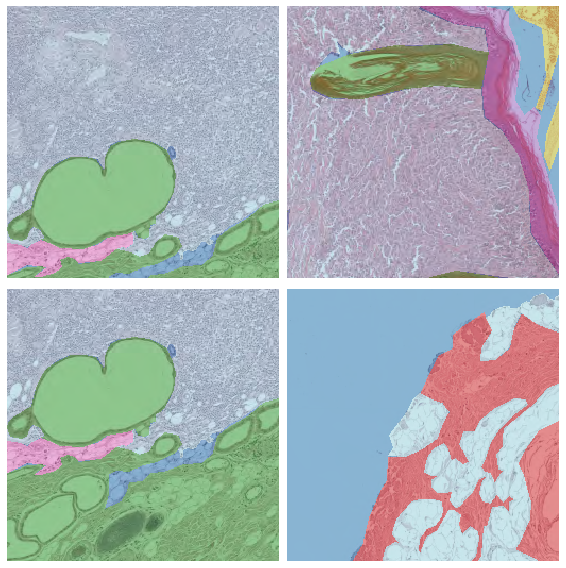

In [10]:
data.show_batch(ds_type=DatasetType.Valid)

## Initalize UNet learner

In [11]:
learn = unet_learner(data, encoder, metrics=[iou, background_iou, dermis_iou, epidermis_iou, subcutis_iou, infl_nec_iou, tumor_iou],callback_fns=[ShowGraph])
learn.loss_func = ComboLoss()

## Start training

epoch,train_loss,valid_loss,iou,background_iou,dermis_iou,epidermis_iou,subcutis_iou,infl_nec_iou,tumor_iou,time
0,1.532761,1.538050,0.169069,0.436874,0.249619,0.061309,0.030503,0.015592,0.389587,01:04
1,1.362794,1.114267,0.252449,0.631437,0.334178,0.004714,0.278531,0.000111,0.518172,00:55
2,1.223420,0.837201,0.217362,0.610650,0.279987,0.018127,0.049832,0.002369,0.560571,00:53
3,1.069531,0.683060,0.275168,0.504114,0.416406,0.008241,0.286917,0.002123,0.708373,00:53
4,1.004631,0.880340,0.314026,0.832691,0.454423,0.028680,0.318435,0.002266,0.561684,00:53


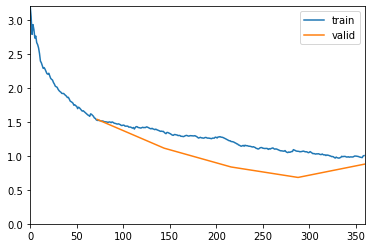

Better model found at epoch 0 with iou value: 0.16906917810610894.
Better model found at epoch 1 with iou value: 0.2524489235460607.
Better model found at epoch 3 with iou value: 0.27516772015396285.
Better model found at epoch 4 with iou value: 0.314025572900325.


In [12]:
learn.fit_one_cycle(5, lr,  callbacks=[SaveModelCallback(learn, every='improvement', monitor='iou',name='segmentation_learner')])

## Let's have a look at some results

In [13]:
def show_patch_results (learn, device, image_container, x_min, y_min, level, patch_size):
    lut = []
    lut.append([255, 255, 255])
    lut.append([0, 0, 255])
    lut.append([0, 255, 255])
    lut.append([255, 0, 0])
    lut.append([255, 20, 147])
    lut.append([255, 128, 0])
    lut = np.array(lut).astype(int)

    image = np.array(image_container.slide.read_region(location=(x_min, y_min), level=level, size=(patch_size, patch_size)))[:, :, :3]
    patch = pil2tensor(image / 255., np.float32)
    patch = transforms.Normalize(*learn.data.stats)(patch)
    gt = image_container.get_y_patch(x_min//np.power(4,level), y_min//np.power(4,level))

    with torch.no_grad():
        prediction = learn.model.eval()(torch.stack([patch]).to(device=device))
        prediction = torch.softmax(prediction, dim=1)
        prediction = prediction.argmax(dim=1)[None]
        prediction = np.squeeze(prediction.cpu(), 0)

        _, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
        ax[0].set_title("Image")
        ax[1].set_title("GT")
        ax[2].set_title("Prediction")

        ax[0].imshow(image)
        ax[1].imshow(lut[gt])
        ax[2].imshow(np.squeeze(lut[prediction], 0))

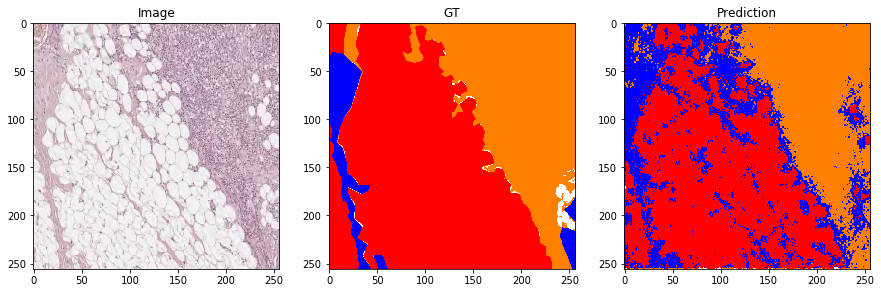

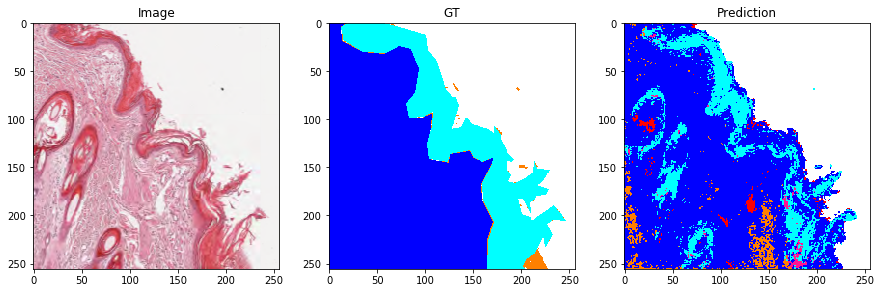

In [14]:
show_patch_results(learn, device, valid_files[0], 20000, 30000, level, patch_size)
show_patch_results(learn, device, valid_files[1], 50000, 10000, level, patch_size)

## Export learner

In [15]:
learn.export('segmentation_learner.pkl')